# **Project: Asset Replacement with Maintenance**



   At the beginning of each year, a manufacturer must decide wheter to continue to operate an aging physical asset or replace it with a new one. If he keep the current asset, he must decide whether to perform annual service maintenance to prevent the asset from failing. An asset that is $s$ years old yields a profit contribution $p(s)$ up to $n=5$ years, at which point the asset becomes unsafe and must be replaced by law. An asset that is $s$ years old and has been maintained $m$ times fails with probability $\mu(s,m)$ and yields a proft of 0 in that year. The cost of a new asset is $c = 75$ and the cost of of servicing an asset is $k=10$.

  What replacement-maintenance policy maximizes profits?

## **Model**

This is an infinite horizon deterministic model with time $t$ measured
in years.

The age is a discrete state variable:
- $s \in \{0, 1, 2, 3, 4, 5\}$

The variable $m$ is the number of times that the asset has failed the maintenance:
- $m \in \{0, 1, 2, 3, 4, 5\}$


The action variable $a$ is the keep-replacement decision:
- $a \in \{$keep, replace$\}$


The state transition function is:
- $t(s, a) = \begin{cases}
  s+1,  & a = \text{ keep}\\
  1, & a = \text{ replace}
\end{cases}$

The reward function is:
- $r(s, a, m) = \begin{cases}
  p(s) - k, & a = \text{ keep, maintenance success} \\
  0 - k & a = \text{keep, maintenance fail with probability}  \frac{s-m}{5}\\
  p(0)- c, & a = \text{ replace}
\end{cases}$

with $p(s) = 50 - 2.5\cdot s - 2.5\cdot s^2$. 

# **Environment**

In [1]:
import gym
from gym import spaces

import numpy as np
from numpy.random import default_rng

from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [2]:
class AssetReplacementEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(AssetReplacementEnv, self).__init__()

        # 0 keep, 1 replace
        n_actions = 2
        self.action_space = spaces.Discrete(n_actions)

        # With spaces.Tuple you can create a multidimensional state
        # In our simple model observation and state are synonyms
        self.n_states = 6
        self.observation_space = spaces.Discrete(self.n_states)

        self.n_maint = 6
        self.maint_space = spaces.Discrete(self.n_maint)
        
        self.service = 10
        self.cost = 75
        self.rng = default_rng()
        
        
    def step(self, action):
        """
        State transition of the model.

        """
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
#%%%%%
        mu = (self.state - self.maint) / 5
#         print("About mu")
#         print("s :" + str(self.state))
#         print("m :" + str(self.maint))
#         print("mu :" + str(mu))
    
        # calculate the reward and the state transition
        if action:  # action = 0 keep, 1 replace
            reward = self.profit(0) - self.cost
            self.state = 1 
            self.maint = 0
        else:
            if self.rng.random() < mu:      # maintenance fail
                reward = 0 - self.service
                self.maint += 1
                self.state += 1 
            else:    
                reward = self.profit(self.state) - self.service  #maintenace success
                self.state += 1 
#%%%%%     


        # This is a continuing task, so done is always false
        done = False

        info = {}
       #print("m:" + str(self.maint))
        return self.state, self.maint, reward, done, info


    def profit(self, state):
        return 50 - 2.5*state - 2.5*state**2
        

    def reset(self):
        # set initial state (age of machine) to 0
        self.state = 0
        self.maint = 0            
 #%%%%5
        return self.state, self.maint


    # We will not implement render and close function
    def render(self, mode='human'):
        pass
    def close (self):
        pass

# **Sarsa Agent**

In [3]:
class SarsaAgent():
    def __init__(self, agent_info):
        """Initialize Agent.

        Args: 
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """

        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        
        self.rng = default_rng()

        # Create a dict for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))         
       
    def step(self, reward, state, maint):
        """A step taken by the agent

        Args:
            next_state (int):  next state from the environment
            next_maint (int):  next state of maintenance failure from environment 
        Returns:
            next_action (int): action the agent takes in next_state
        """

        # choose action using epsilon greedy policy
        action = self.select_action(state, maint)

        # perform update
        target = reward + self.discount*self.q[state, maint][action]
        td_error = target - self.q[self.previous_state,self.previous_maint][self.previous_action]
        self.q[self.previous_state,self.previous_maint][self.previous_action] += self.step_size* td_error
        

        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

        
    def select_action(self, state, maint):
        """Select action using epsilon greedy policy.

        Args:
            state (int): Current state, i.e. age of asset.

        Returns:
            action (int): Action the agent takes.
        """

        
        # performe epsilon greedy policy improvement
        # remember to replace asset if age is 5
 #%%%%
        if state== 5 or maint == 5:
            return 1
        if  self.rng.random() < self.epsilon:
            action = self.rng.choice(n_actions)
        else:
            action = self.argmax(self.q[state, maint])
        return action
        
 
    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """
        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)
#         print(ties)
#         print("argmax index:" + str(index))
        return index


    def start(self, state, maint):
        """Selects action in inital state

        Args:
            state (int): initial state
            maint (int): intial times of maintenance failure
        Returns:
            action (int): initial action
        """

        action = self.select_action(state, maint)

        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action



In [4]:
env = AssetReplacementEnv()

n_actions = env.action_space.n
epsilon = 0.05
step_size = 0.2
discount = 0.9


agent_info = {"n_actions": n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = SarsaAgent(agent_info)

n_episodes = 500
timesteps = 20

for i in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)

    for t in range(timesteps):
        state, maint, reward,  _, _ = env.step(action)
        action = agent.step(reward, state, maint)
    

In [5]:
# Perform path simulation
state, maint = env.reset()
action = agent.start(state, maint)

state_path = [state]
maint_path = [maint]
action_path = [action]


for t in range(timesteps):
    state, maint, reward, _, _ = env.step(action)
    action = agent.step(reward, state, maint)

    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)


---

**Plot the episode**


---


In [6]:
# extract the value function from action value function
V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action


In [7]:
V

defaultdict(float,
            {(0, 0): 87.97423833778922,
             (1, 0): 48.68305098244973,
             (2, 0): 28.126001204770347,
             (2, 1): 37.2991626421524,
             (3, 0): 23.675242879778708,
             (3, 1): 21.030591194807755,
             (3, 2): 28.284646104350635,
             (4, 0): 19.189528386179575,
             (4, 1): 23.608446861736777,
             (4, 2): 18.967793875989237,
             (4, 3): 15.731869512641955,
             (5, 0): 0.0,
             (5, 1): 5.572559325171371,
             (5, 2): 13.509829564814833,
             (5, 3): 7.925488905352891})

In [8]:
X =  np.array([x[0] for x in list(V.keys())])

In [9]:
Y = np.array([x[1] for x in list(V.keys())])

In [10]:
Z = np.array( list(V.values()))

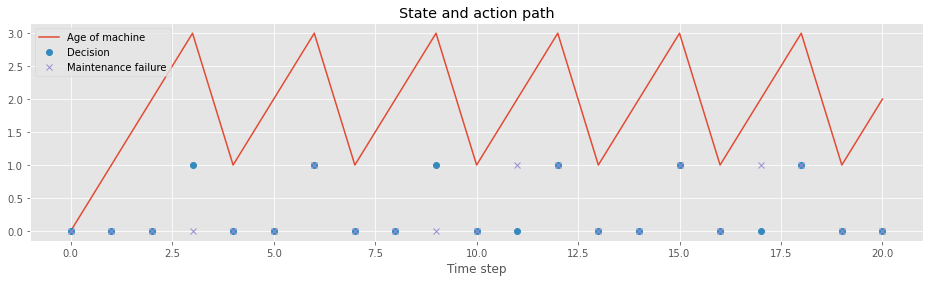

In [11]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, 'x', label='Maintenance failure')
plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
plt.show()

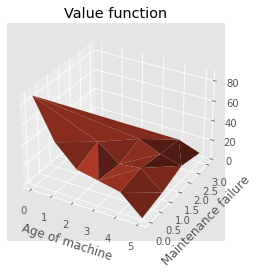

In [12]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(X,Y,Z)
ax.set_title('Value function')
ax.set_xlabel('Age of machine')
ax.set_ylabel( 'Maintenance failure')
plt.show()

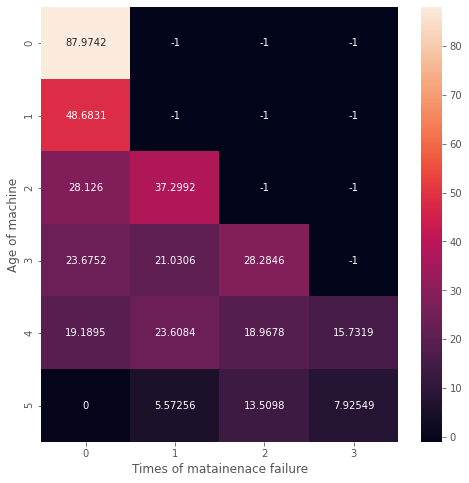

In [13]:
import pandas as pd
import seaborn as sns
plt.figure(figsize=(8,8))
ser = pd.Series(list(V.values()),
                  index= pd.MultiIndex.from_tuples( V.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.show()

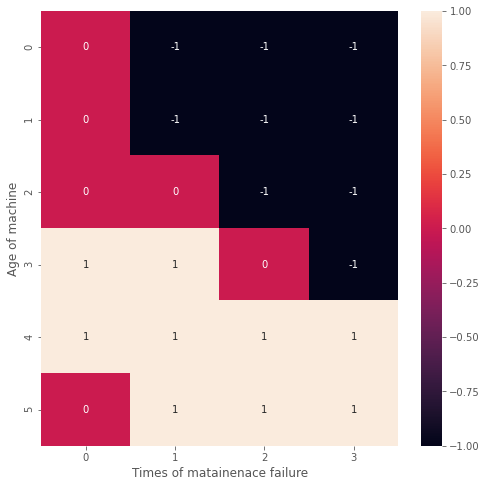

In [14]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(policy.values()),
                  index= pd.MultiIndex.from_tuples( policy.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.show()

# **Q-Learning Agent**

In [15]:
class QLearningAgent():
    def __init__(self, agent_info):
        """Initialize Agent

        Args: 
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """
        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        self.rng = default_rng()

        # Create an array for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))      


    def step(self, reward, state, maint):
        """A step taken by the agent

        Args:
            next_state (int):  next state from the environment
            next_maint (int):  next state of maintenance failure from environment 
        Returns:
            next_action (int): action the agent takes in next_state
        """

        # choose action using epsilon greedy policy
        action = self.select_action(state, maint)

  
        # perform update
        target = reward + self.discount* np.max(self.q[state, maint])
        td_error = target- self.q[self.previous_state, self.previous_maint][self.previous_action]
        self.q[self.previous_state, self.previous_maint][self.previous_action] += self.step_size * td_error
     

        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

        
    def select_action(self, state, maint):
        """Select action using epsilon greedy policy

        Args:
            state (int): current state
            maint (int): current times of maitenance failure
        Returns:
            action (int): action the agent takes
        """
        
        # performe epsilon greedy policy improvement
        # remember to replace asset if age is 5
        if state==5 or maint == 5:
            return 1
        if  self.rng.random() < self.epsilon:
            action = self.rng.choice(n_actions)
        else:
            action = self.argmax(self.q[state, maint])
        return action


    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)

        return index


    def start(self, state, maint):
        """Selects action in inital state

        Args:
            state (int): initial state
            maint (int): initial maint
        Returns:
            action (int): initial action
        """

        action = self.select_action(state, maint)

        self.previous_maint= maint
        self.previous_state = state
        self.previous_action = action

        return action


In [16]:
env = AssetReplacementEnv()

n_actions = env.action_space.n
epsilon = 0.2
step_size = 0.4
discount = 0.9


agent_info = {"n_actions": n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = QLearningAgent(agent_info)

n_episodes = 500
timesteps = 20

for i in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)
  
    for t in range(timesteps):
        state, maint, reward, _, _ = env.step(action)
        action = agent.step(reward, state, maint)


In [17]:
# Perform path simulation
state, maint = env.reset()

agent.epsilon = 0
action = agent.start(state, maint)


state_path = [state]
maint_path = [maint]
action_path = [action]

for t in range(timesteps):
    state, maint, reward, done, _ = env.step(action)
    action = agent.step(reward, state, maint)

    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)

In [18]:
# extract the value and policy function from action value function
V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    action = np.argmax(values)
    policy[state_maint] = action
    V[state_maint] = value


In [19]:
policy

defaultdict(int,
            {(0, 0): 0,
             (1, 0): 0,
             (2, 0): 1,
             (2, 1): 0,
             (3, 0): 1,
             (3, 1): 1,
             (3, 2): 0,
             (4, 0): 1,
             (4, 1): 1,
             (4, 2): 1,
             (4, 3): 1,
             (5, 1): 1,
             (5, 2): 1,
             (5, 3): 1})

In [20]:
V

defaultdict(float,
            {(0, 0): 76.9163093542042,
             (1, 0): 54.43464239269322,
             (2, 0): 22.469065670358614,
             (2, 1): 22.494604086830762,
             (3, 0): 28.402736722808847,
             (3, 1): 23.223471132004498,
             (3, 2): 20.323112370354274,
             (4, 0): 27.664553061694,
             (4, 1): 13.45131797880166,
             (4, 2): 19.987601454314344,
             (4, 3): 16.229334480969793,
             (5, 1): 16.738337645415598,
             (5, 2): 12.50220214361377,
             (5, 3): 15.166405833861047})

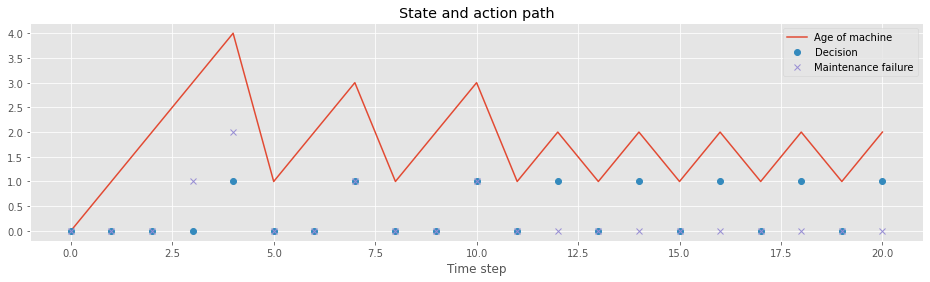

In [21]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, 'x', label='Maintenance failure')
plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
plt.show()


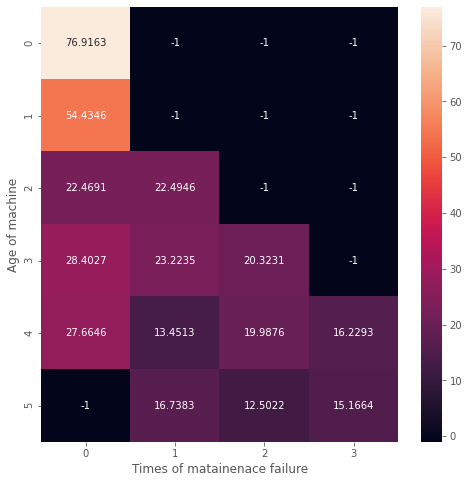

In [22]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(V.values()),
                  index= pd.MultiIndex.from_tuples( V.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.show()

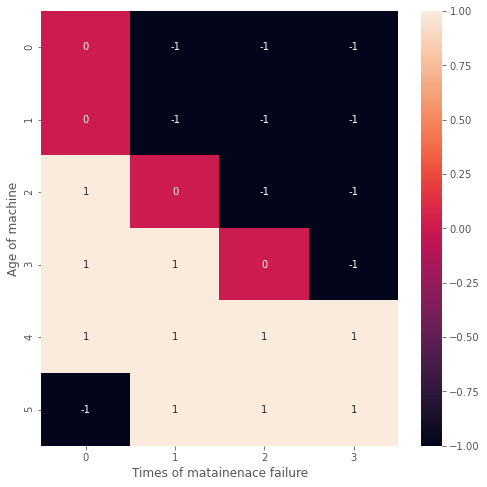

In [23]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(policy.values()),
                  index= pd.MultiIndex.from_tuples( policy.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.show()

# **Expected Sarsa**

In [24]:
class ExpectedSarsaAgent():
    def __init__(self, agent_info):
        """Initialize Agent.

        Args: 
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """

        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        self.rng = default_rng()

        # Create an array for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))        


    def step(self, reward, state, maint):
        """A step taken by the agent

        Args:
            next_state (int):  next state from the environment
            next_maint (int):  next state of maintenance failure from environment 
        Returns:
            next_action (int): action the agent takes in next_state
        """

         # choose action using epsilon greedy policy
        action = self.select_action(state, maint)  

        # perform update
        policy = np.ones(self.n_actions)*self.epsilon/self.n_actions
        policy[np.argmax(self.q[state, maint])] += 1 - self.epsilon

        expectation = self.q[state, maint] @ policy


        target = reward + self.discount * expectation
        td_error = target - self.q[self.previous_state, self.previous_maint][self.previous_action]
        self.q[self.previous_state, self.previous_maint][self.previous_action] += self.step_size * td_error



        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

        
    def select_action(self, state, maint):
        """Select action using epsilon greedy policy

        Args:
            state (int): current state
            maint (int): current times of maitenance failure
        Returns:
            action (int): action the agent takes
        """
        if state == 5 or maint == 5:
            return 1

        current_q  = self.q[state, maint]
        if self.rng.random() < self.epsilon:
            action = self.rng.choice(self.n_actions)
        else:
            action = self.argmax(current_q)

        return action
        

    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)

        return index


    def start(self, state, maint):
        """Selects action in inital state

        Args:
            state (int): initial state
            maint (int): initial maint
        Returns:
            action (int): initial action
        """

        action = self.select_action(state, maint)

        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

In [25]:
env = AssetReplacementEnv()

num_actions = env.action_space.n
epsilon = 0.05
step_size = 0.2
discount = 0.9


agent_info = {"n_actions": n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = ExpectedSarsaAgent(agent_info)


n_episodes = 500
timesteps = 20

for _ in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)

    for t in range(timesteps):
        state, maint, reward, _, _ = env.step(action)
        action = agent.step(reward, state, maint)


In [26]:
# Perform path simulation
state, maint = env.reset()
action = agent.start(state, maint)

state_path = [state]
maint_path = [maint]
action_path = [action]

for t in range(timesteps):
    state, maint, reward, done, _ = env.step(action)
    action = agent.step(reward, state, maint)

    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)

In [27]:
V

defaultdict(float,
            {(0, 0): 76.9163093542042,
             (1, 0): 54.43464239269322,
             (2, 0): 22.469065670358614,
             (2, 1): 22.494604086830762,
             (3, 0): 28.402736722808847,
             (3, 1): 23.223471132004498,
             (3, 2): 20.323112370354274,
             (4, 0): 27.664553061694,
             (4, 1): 13.45131797880166,
             (4, 2): 19.987601454314344,
             (4, 3): 16.229334480969793,
             (5, 1): 16.738337645415598,
             (5, 2): 12.50220214361377,
             (5, 3): 15.166405833861047})

In [28]:
# extract the value and policy function from action value function
V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action
    

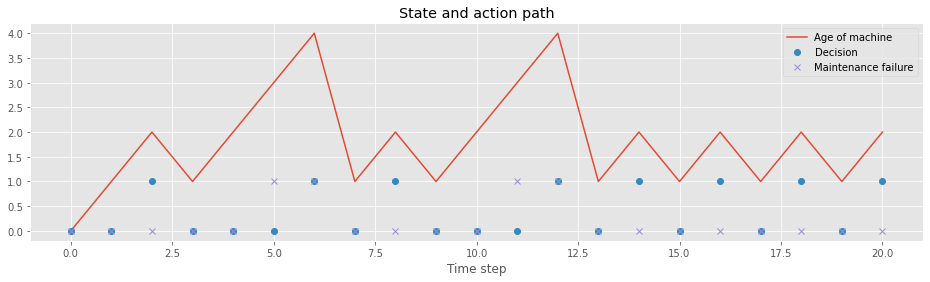

In [29]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, 'x', label='Maintenance failure')
plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
plt.show()


In [34]:
V

defaultdict(float,
            {(0, 0): 84.1222002808312,
             (1, 0): 47.140063537104865,
             (2, 0): 16.050853970239025,
             (2, 1): 39.58283698273672,
             (3, 0): 23.162983296941466,
             (3, 1): 23.766612519509792,
             (3, 2): 16.647856193434432,
             (4, 0): 25.919437153578343,
             (4, 1): 15.263270048004747,
             (4, 2): 20.82652075434692,
             (4, 3): 7.713690573523174,
             (5, 1): 7.7519884973199265,
             (5, 2): 14.818426693101566,
             (5, 3): 12.420384946020565})

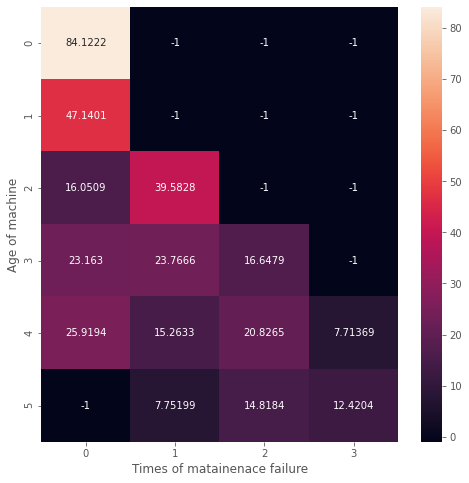

In [30]:

plt.figure(figsize=(8,8))
ser = pd.Series(list(V.values()),
                  index= pd.MultiIndex.from_tuples( V.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.show()

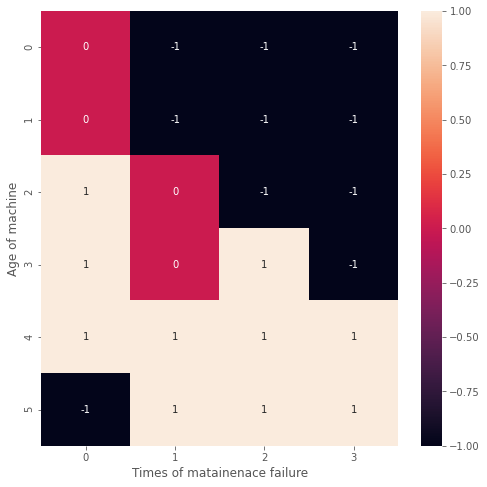

In [32]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(policy.values()),
                  index= pd.MultiIndex.from_tuples( policy.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.show()